# Titanic: Who will survive?
## Author Dustin Burnham
### Date Started: 9/29/2019

#### Outline:
1. Read in Data
2. Clean Data
3. EDA
4. Build and Test Logistic Regression Model
5. Build and Test Random Forrest Model
6. Build and Test XGBoosted Ensemble Model
7. Summary

The purpose of this project is to predict who survived the sinking of the Titanic based off of their personal information.  I will try using a logistic regression, random forrest, and XGBoosted ensemble models to classify into "1" survived, and "0" did not survive.  The data has already been split by the folks at Kaggle into training and testing data, however I will combine them for the purpose of EDA.

In [138]:
# Read in Libraries
from sklearn import svm, metrics
import pandas as pd
import numpy as np
import seaborn as sns
from collections import Counter
import category_encoders as ce
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline

### Read in data

In [139]:
# Read in data
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

### 2. Clean Data

In [140]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [141]:
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [142]:
train_data.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [143]:
train_data.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [144]:
len(train_data)

891

In [145]:
test_data.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [146]:
len(test_data)

418

#### Decision:
For creating a model, I will drop the "PassengerID", "Name", and "Cabin" columns.  Roughly 75% of the cabin values are NA, however we might be able to do some feature engineering to get the first letter of the Cabin.

In [147]:
train_data = train_data.drop(["PassengerId", "Name", "Cabin", "Ticket"], axis = 1)
test_data = test_data.drop(["PassengerId", "Name", "Cabin", "Ticket"], axis = 1)

#### Fix NAs in the age variable

In [148]:
med_male_age = np.nanmedian(train_data.loc[train_data["Sex"] == "male",'Age'])
mean_male_age = np.nanmean(train_data.loc[train_data["Sex"] == "male",'Age'])
med_female_age = np.nanmedian(train_data.loc[train_data["Sex"] == "female",'Age'])
mean_female_age = np.nanmean(train_data.loc[train_data["Sex"] == "female",'Age'])

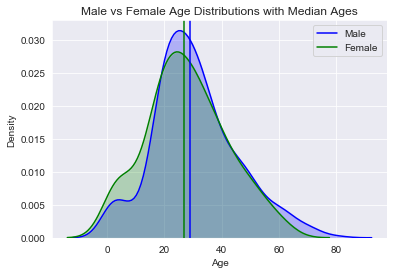

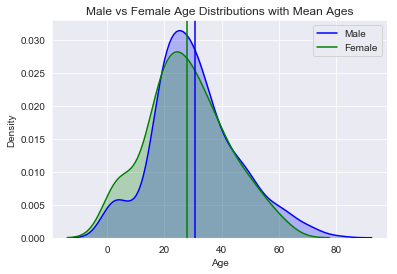

In [149]:
sns.set_style("darkgrid")
sns.kdeplot(train_data.loc[train_data["Sex"] == "male",'Age'].dropna(axis=0), shade = True, label ="Male", color = 'b')
sns.kdeplot(train_data.loc[train_data["Sex"] == "female",'Age'].dropna(axis=0), shade = True, label ="Female", color = 'g')
plt.axvline(med_male_age, 0,1, color = 'b', label = "Median Age Male")
plt.axvline(med_female_age, 0,1, color = 'g', label = "Median Age Female")
plt.xlabel("Age")
plt.ylabel("Density")
plt.title("Male vs Female Age Distributions with Median Ages")
plt.show()

sns.kdeplot(train_data.loc[train_data["Sex"] == "male",'Age'].dropna(axis=0), shade = True, label = "Male", color = 'b')
sns.kdeplot(train_data.loc[train_data["Sex"] == "female",'Age'].dropna(axis=0), shade = True, label = "Female", color = 'g')
plt.axvline(mean_male_age, 0,1, color = 'b', label = "Mean Age Male")
plt.axvline(mean_female_age, 0,1, color = 'g', label = "Mean Age Female")
plt.xlabel("Age")
plt.ylabel("Density")
plt.title("Male vs Female Age Distributions with Mean Ages")
plt.show()

In [150]:
print("Male Median Age: %3.2f" % med_male_age)
print("Male Mean Age: %3.2f" % mean_male_age)
print("Feale Median Age: %3.2f" % med_female_age)
print("Feale Mean Age: %3.2f" % mean_female_age)

Male Median Age: 29.00
Male Mean Age: 30.73
Feale Median Age: 27.00
Feale Mean Age: 27.92


#### Decision:
Because the distributions are right skewed, I will use the median instead of mean for each gender to replace NaN values.

In [151]:
train_data.loc[(train_data["Age"].isnull()) & (train_data['Sex'] == "female"),"Age"] = med_female_age
train_data.loc[(train_data["Age"].isnull()) & (train_data['Sex'] == "male"),"Age"] = med_male_age
test_data.loc[(test_data["Age"].isnull()) & (test_data['Sex'] == "female"),"Age"] = med_female_age
test_data.loc[(test_data["Age"].isnull()) & (test_data['Sex'] == "male"),"Age"] = med_male_age

Text(0.5, 1.0, 'Fare Distribution')

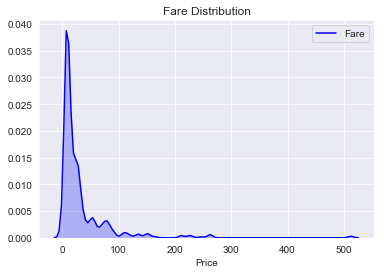

In [152]:
sns.kdeplot(train_data["Fare"], color = 'b', shade = True)
plt.xlabel("Price")
plt.title("Fare Distribution")

In [153]:
train_data.isna().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    2
dtype: int64

In [154]:
test_data.isna().sum()

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        1
Embarked    0
dtype: int64

#### Decision:
Because the distribution is very right skewed and non-normal, I will just drop the one row with NaN price.

In [155]:
print('Resampled dataset shape {}'.format(Counter(train_data["Embarked"])))

Resampled dataset shape Counter({'S': 644, 'C': 168, 'Q': 77, nan: 2})


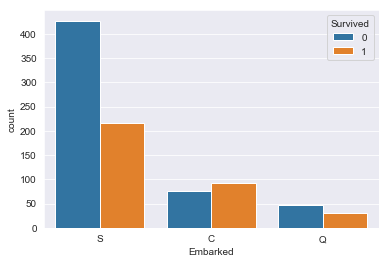

In [156]:
sns.countplot(x = "Embarked", hue = "Survived", data=train_data)

#### Decision:
Because the classification of where a person embarked from has an impact on whether a person survived or not, I will drop the two rows that have no embarked.

In [157]:
train_data = train_data.dropna(axis=0)
test_data = test_data.dropna(axis=0)

In [158]:
cat_vars_train = list(train_data.dtypes.index[train_data.dtypes == 'object'])
cat_vars_test = list(test_data.dtypes.index[test_data.dtypes == 'object'])

In [159]:
# One hot encode variables
handle = "value" # error return_nan value indicator
onehoter =  ce.OneHotEncoder(return_df = True, 
                       cols = cat_vars_train, 
                       drop_invariant = False,
                       use_cat_names = True, 
                       handle_missing = handle, 
                       handle_unknown = handle)

onehoter.fit(train_data)
encoded_train = onehoter.transform(train_data)

handle = "value" # error return_nan value indicator
onehoter =  ce.OneHotEncoder(return_df = True, 
                       cols = cat_vars_test, 
                       drop_invariant = False,
                       use_cat_names = True, 
                       handle_missing = handle, 
                       handle_unknown = handle)
onehoter.fit(test_data)
encoded_test = onehoter.transform(test_data)

In [180]:
# Scale train and test data using min max scaling
names = encoded_train.columns
scaler = MinMaxScaler()
scaler.fit(encoded_train)
scaled_train = scaler.transform(encoded_train)
scaled_train = pd.DataFrame(scaled_train, columns=names)

names = encoded_test.columns
scaler = MinMaxScaler()
scaler.fit(encoded_test)
scaled_test = scaler.transform(encoded_test)
scaled_test = pd.DataFrame(scaled_test, columns=names)

## Summary:

### 3. EDA

In [181]:
scaled_train.head()

,Survived,Pclass,Sex_male,Sex_female,Age,SibSp,Parch,Fare,Embarked_S,Embarked_C,Embarked_Q
0,0.0,1.0,1.0,0.0,0.271174,0.125,0.0,0.014151,1.0,0.0,0.0
1,1.0,0.0,0.0,1.0,0.472229,0.125,0.0,0.139136,0.0,1.0,0.0
2,1.0,1.0,0.0,1.0,0.321438,0.000,0.0,0.015469,1.0,0.0,0.0
3,1.0,0.0,0.0,1.0,0.434531,0.125,0.0,0.103644,1.0,0.0,0.0
4,0.0,1.0,1.0,0.0,0.434531,0.000,0.0,0.015713,1.0,0.0,0.0


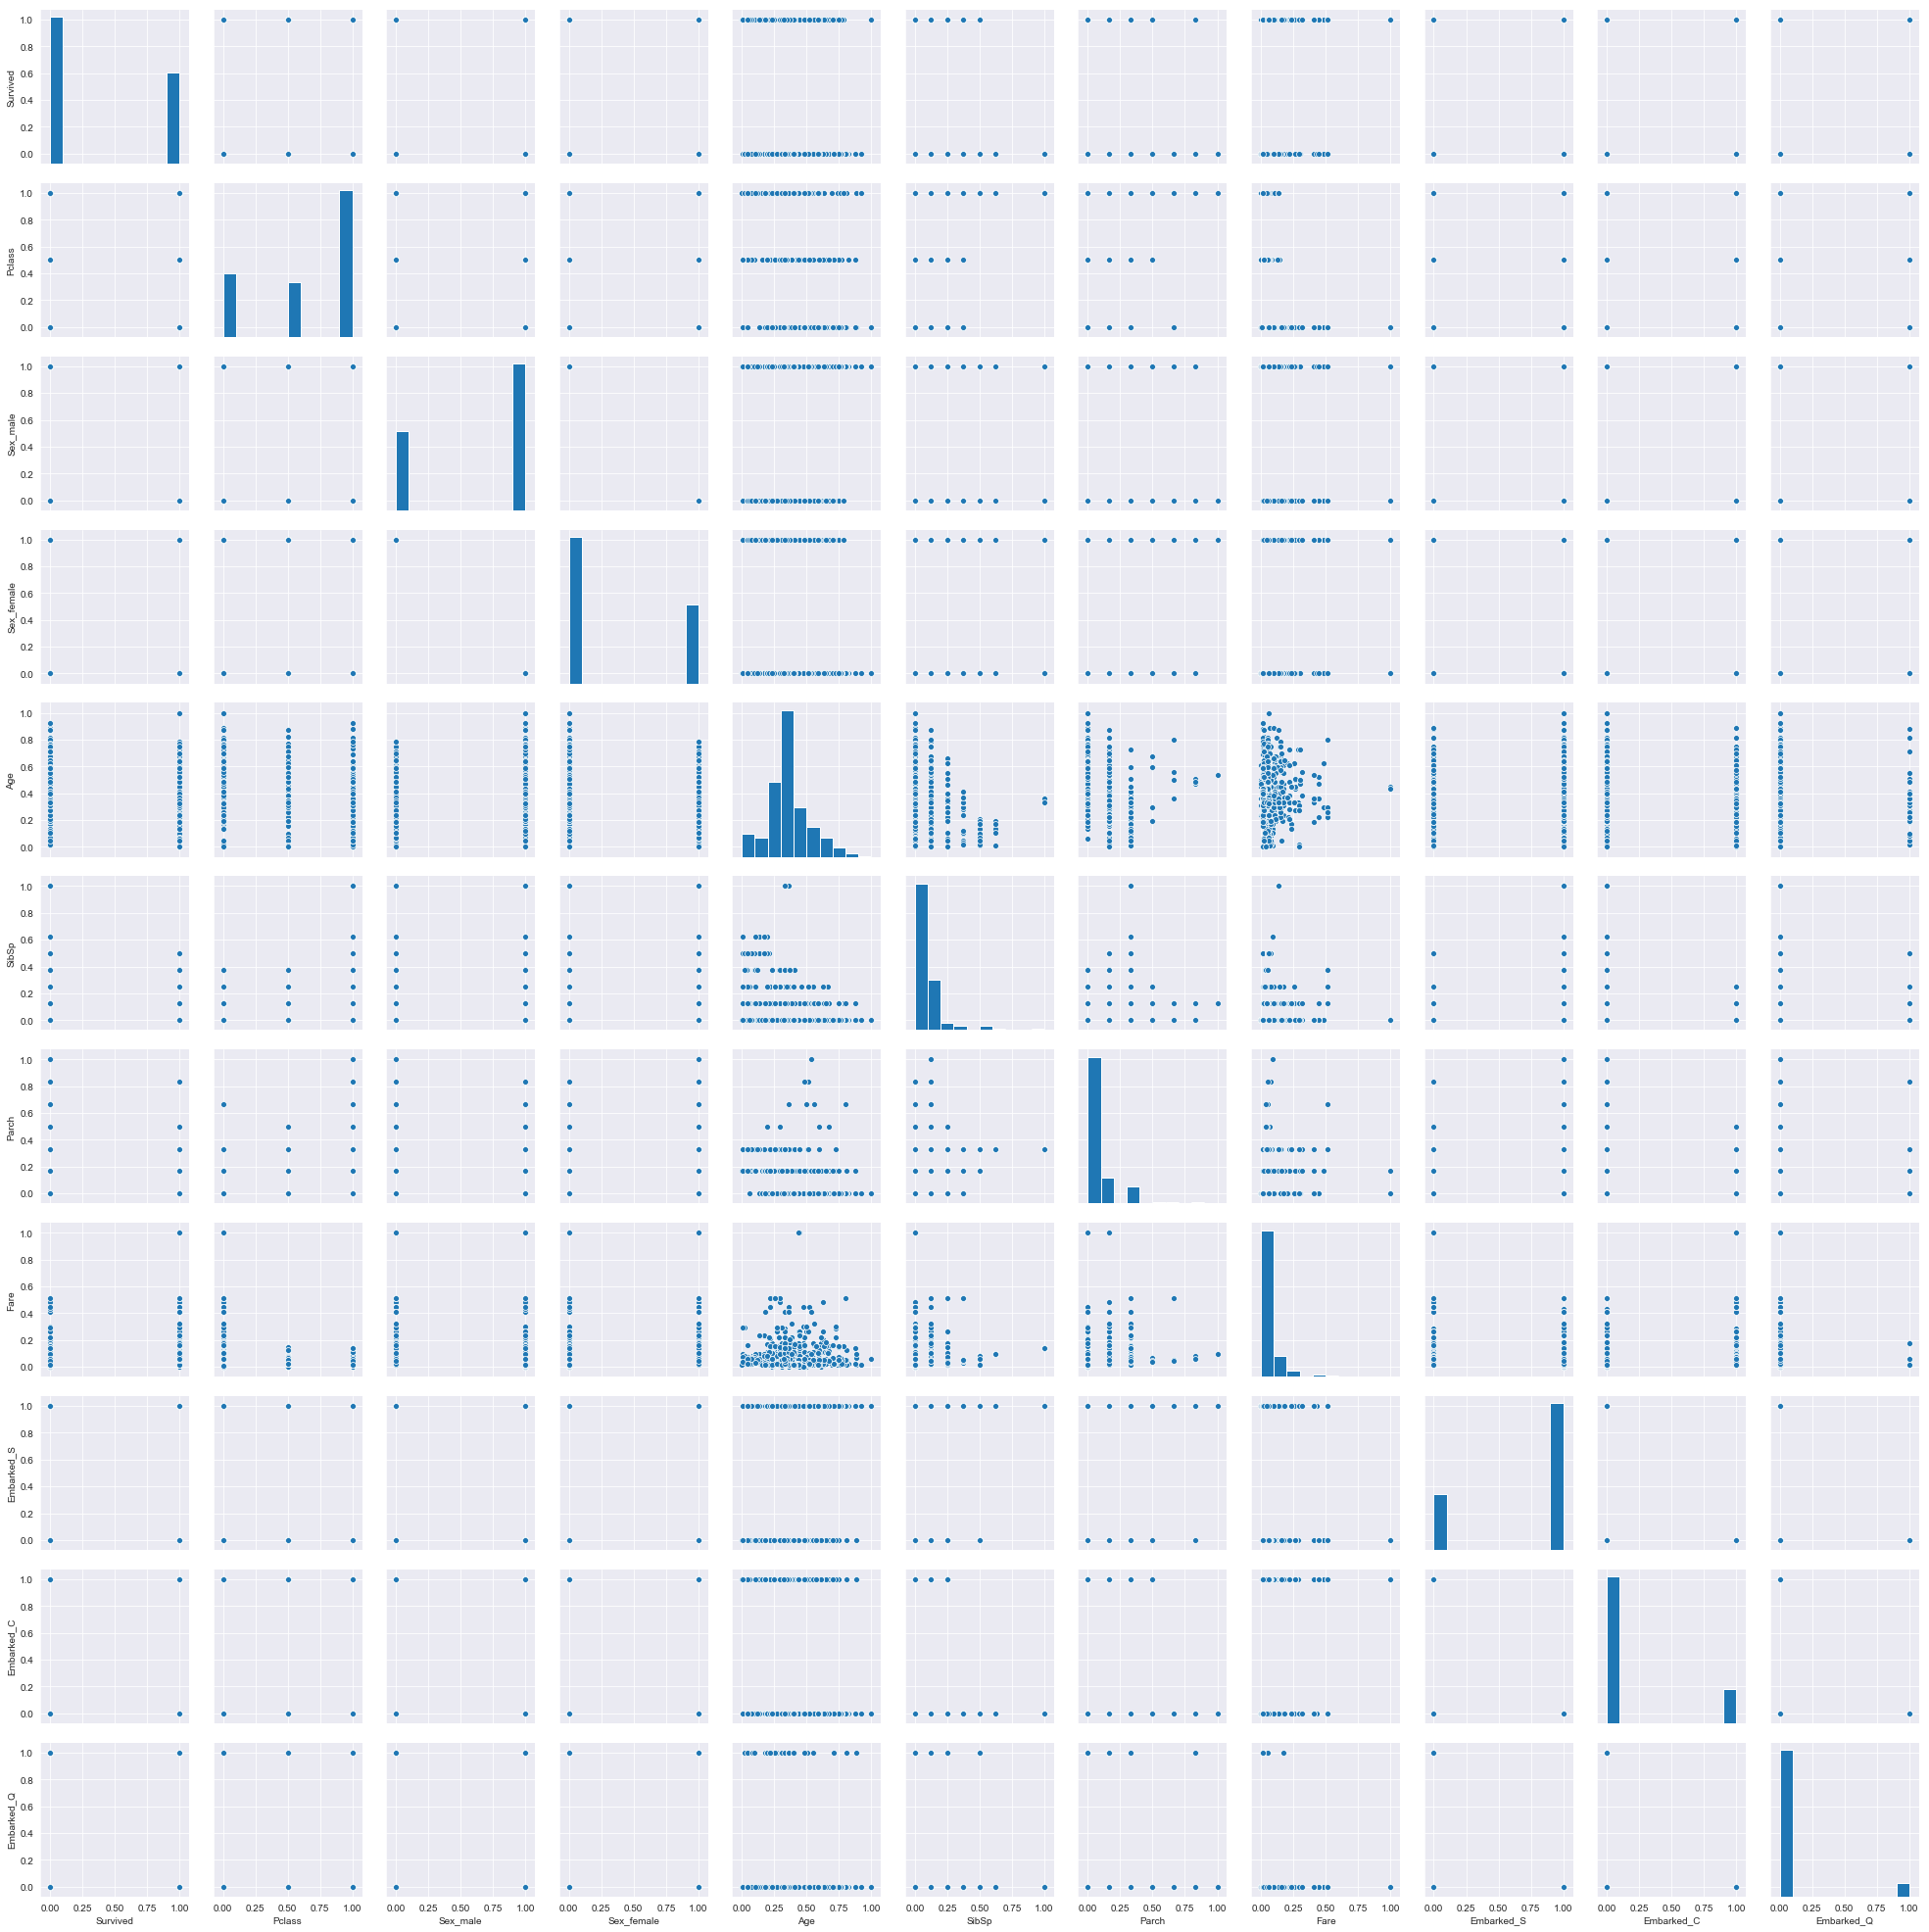

In [182]:
sns.pairplot(scaled_train)

### 4. Logistic Regression Model